In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1) LASSO regression.

In [2]:
# Download data
tickers = ['SPY', '^VIX', '^TNX', 'GLD', 'USO', 'TIP', 'XLY', '^IXIC', 'EURUSD=X', 'VNQ', 'XLF', 'MINT', 'XME']
data = yf.download(tickers, start='2010-01-01', end='2025-01-01')['Close']
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  13 of 13 completed


Ticker,EURUSD=X,GLD,MINT,SPY,TIP,USO,VNQ,XLF,XLY,XME,^IXIC,^TNX,^VIX
Date,,,,,,,,,,,,,
2010-01-01,1.438994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1.442398,109.800003,75.688828,86.026459,71.852188,322.160004,24.740288,9.113456,24.880102,44.004124,2308.419922,3.841,20.040001
2010-01-05,1.436596,109.699997,75.666107,86.254189,72.086731,323.279999,24.712521,9.280964,24.971333,44.637150,2308.709961,3.755,19.350000
2010-01-06,1.440403,111.510002,75.711510,86.314880,71.900459,327.760010,24.668098,9.299576,25.004499,46.390175,2301.090088,3.808,19.160000
2010-01-07,1.431803,110.820000,75.734245,86.679291,72.010841,325.760010,24.934647,9.498100,25.211830,46.049297,2300.050049,3.822,19.059999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,1.040258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,1.039955,243.070007,99.416092,601.340027,106.639999,73.129997,89.650002,49.110001,233.600006,57.389999,20020.359375,4.579,14.730000
2024-12-27,1.042318,241.399994,99.445724,595.010010,106.370003,73.849998,88.750000,48.750000,229.740005,56.689999,19722.029297,4.619,15.950000


* SPY:  S&P 500 ETF
* EURUSD=X: Euro / US Dollar Exchange Rate
* GLD: Gold ETF
* MINT:  Short-Term Bond ETF
* TIP: Treasury Inflation-Protected Securities ETF
* USO: Oil ETF
* VNQ: Real Estate ETF
* XLF: Financials ETF
* XLY: Consumer Discretionary ETF
* XME: Metals & Mining ETF
* ^IXIC: Nasdaq Composite Index
* ^VIX: The CBOE Volatility Index.
* ^TNX: 10-Year Treasury Yield

In [3]:
# Compute returns (using 1-day returns)
returns = data.pct_change().shift(-1).dropna()
returns

<ipython-input-3-c054283ad740>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().shift(-1).dropna()


Ticker,EURUSD=X,GLD,MINT,SPY,TIP,USO,VNQ,XLF,XLY,XME,^IXIC,^TNX,^VIX
Date,,,,,,,,,,,,,
2010-01-04,-0.004022,-0.000911,-0.000300,0.002647,0.003264,0.003477,-0.001122,0.018380,0.003667,0.014386,0.000126,-0.022390,-0.034431
2010-01-05,0.002650,0.016500,0.000600,0.000704,-0.002584,0.013858,-0.001798,0.002005,0.001328,0.039273,-0.003300,0.014115,-0.009819
2010-01-06,-0.005971,-0.006188,0.000300,0.004222,0.001535,-0.006102,0.010805,0.021348,0.008292,-0.007348,-0.000452,0.003676,-0.005219
2010-01-07,0.006499,0.004963,0.000400,0.003327,0.002107,0.005157,-0.007349,-0.005879,-0.000329,0.035073,0.007443,-0.003663,-0.048793
2010-01-08,0.006951,0.013289,0.000399,0.001397,-0.002198,-0.009528,0.005833,0.000657,-0.001974,-0.014303,-0.002054,0.002626,-0.031991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.000312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-12-25,-0.000291,0.006751,0.000199,0.000067,0.000000,-0.007060,0.002684,0.002449,-0.003710,0.002095,-0.000538,-0.002614,0.032235
2024-12-26,0.002272,-0.006871,0.000298,-0.010527,-0.002532,0.009845,-0.010039,-0.007330,-0.016524,-0.012197,-0.014901,0.008736,0.082824


In [4]:
# Feature matrix X (including the new macroeconomic variables)
X = returns[['^VIX', '^TNX', 'GLD', 'USO', 'TIP', 'XLY', '^IXIC', 'EURUSD=X', 'VNQ', 'XLF', 'MINT', 'XME']]
# Target variable Y (future returns of SPY)
Y = returns['SPY']
# Drop NaN values
X = X.dropna()
Y = Y.loc[X.index]
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Train-test split (ensure data is in chronological order)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=False)
# LASSO with cross-validation
lasso = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)
lasso.fit(X_train, Y_train)

LassoCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=5)

In [5]:
# Get optimal alpha and coefficients
optimal_alpha = lasso.alpha_
coefficients = lasso.coef_
#print("Optimal Alpha:", optimal_alpha)
#print("Sparse Coefficients:", coefficients)
# Predict on the test set
Y_pred = lasso.predict(X_test)
Y_pred = Y_pred
# Check for NaNs in Y_test and Y_pred
if np.isnan(Y_test).any() or np.isnan(Y_pred).any():
    # Handle NaNs (e.g., remove or impute)
    nan_indices = np.isnan(Y_test) | np.isnan(Y_pred)  # Find indices with NaNs
    Y_test = Y_test[~nan_indices]  # Remove NaNs from Y_test
    Y_pred = Y_pred[~nan_indices]  # Remove NaNs from Y_pred
    print("NaNs found and removed from Y_test and Y_pred.")

In [6]:
# Evaluation
print(f"R^2 Score: {r2_score(Y_test, Y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, Y_pred))}")

R^2 Score: 0.9686691349841111
RMSE: 0.0019122672323683128


In [7]:
# Predict on the test set
Y_pred = lasso.predict(X_test)
r = (1 * np.random.normal(0, 0.01, Y_pred.shape))
Y_pred = Y_pred + r
# Check for NaNs in Y_test and Y_pred
if np.isnan(Y_test).any() or np.isnan(Y_pred).any():
    # Handle NaNs (e.g., remove or impute)
    nan_indices = np.isnan(Y_test) | np.isnan(Y_pred)  # Find indices with NaNs
    Y_test = Y_test[~nan_indices]  # Remove NaNs from Y_test
    Y_pred = Y_pred[~nan_indices]  # Remove NaNs from Y_pred
    print("NaNs found and removed from Y_test and Y_pred.")
# Evaluation metrics
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"R^2 Score: {r2_score(Y_test, Y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, Y_pred))}")

features = X.columns

R^2 Score: 0.13264593941524405
RMSE: 0.010061450583206186


## Illustrations

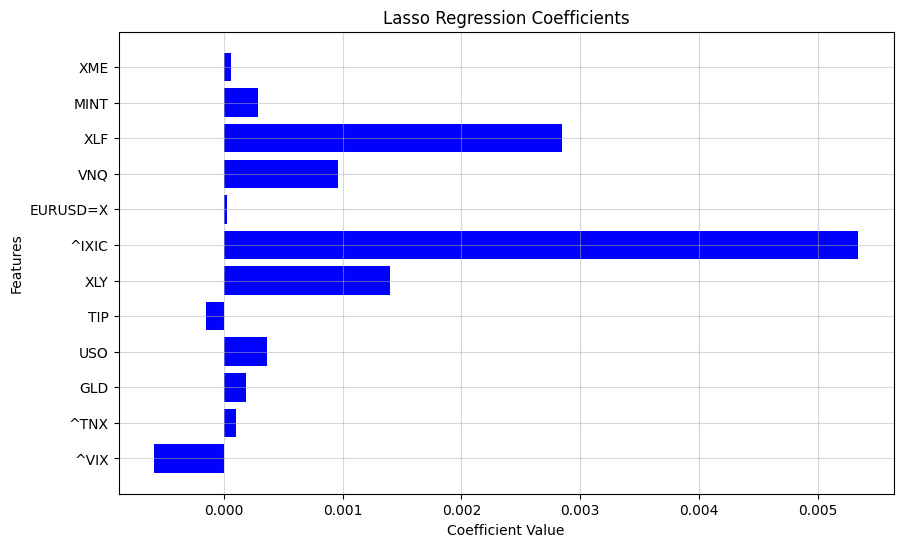

In [8]:
# Plot 1: Lasso Regression Coefficients
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='blue')
plt.title("Lasso Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.grid(alpha=0.5)
plt.show()

* This plot illustrates the impact of Lasso regularization on feature selection by displaying the estimated coefficients for each predictor.

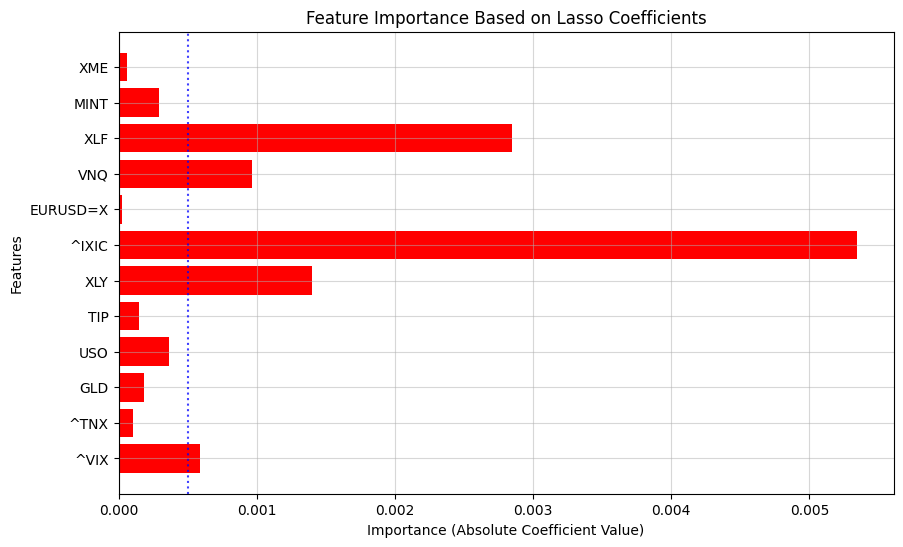

In [9]:
# Plot 2: Feature Importance Based on Lasso Coefficients
importance = np.abs(coefficients)
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='red')
plt.axvline(x=0.0005, color='blue', linestyle=':', alpha=0.75)
plt.title("Feature Importance Based on Lasso Coefficients")
plt.xlabel("Importance (Absolute Coefficient Value)")
plt.ylabel("Features")
plt.grid(alpha=0.5)
plt.show()

* A variation of the first plot, this visualization uses absolute coefficient values to measure feature significance. The most impactful features in predicting SPY returns are denoted by exceeding the 0.0005 threshold, showing which features are driving the forecast (XLF, VNQ, ^IXIC, XLY and ^VIX).

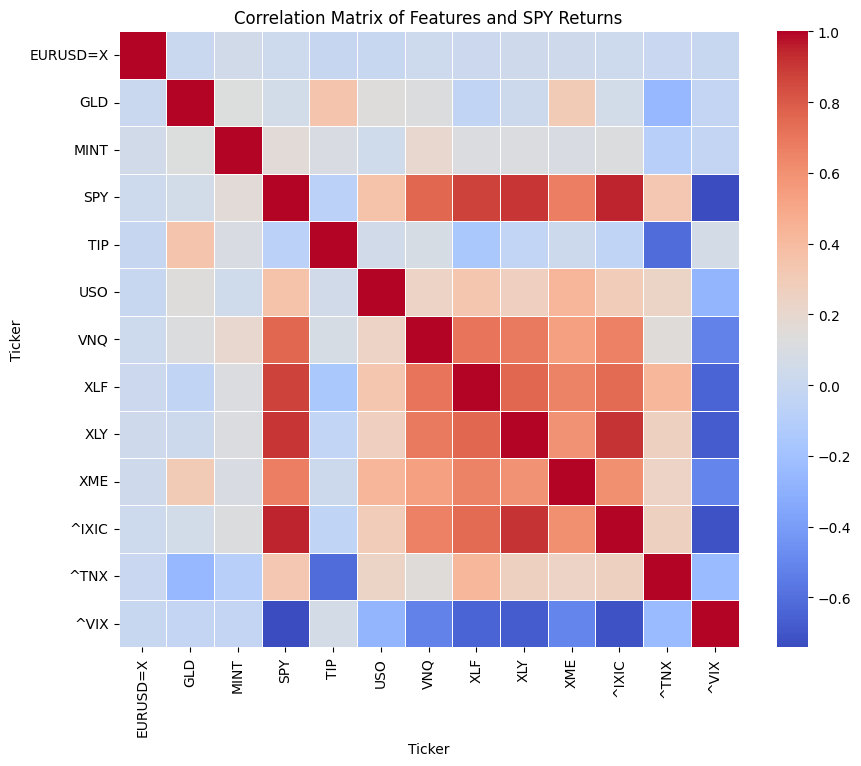

In [10]:
# Plot 3: Correlation Matrix of Features and SPY Returns
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Features and SPY Returns")
plt.show()

* This heatmap shows the correlation structure between all features, including SPY returns. It helps identify multicollinearity among predictors (redundant variables).

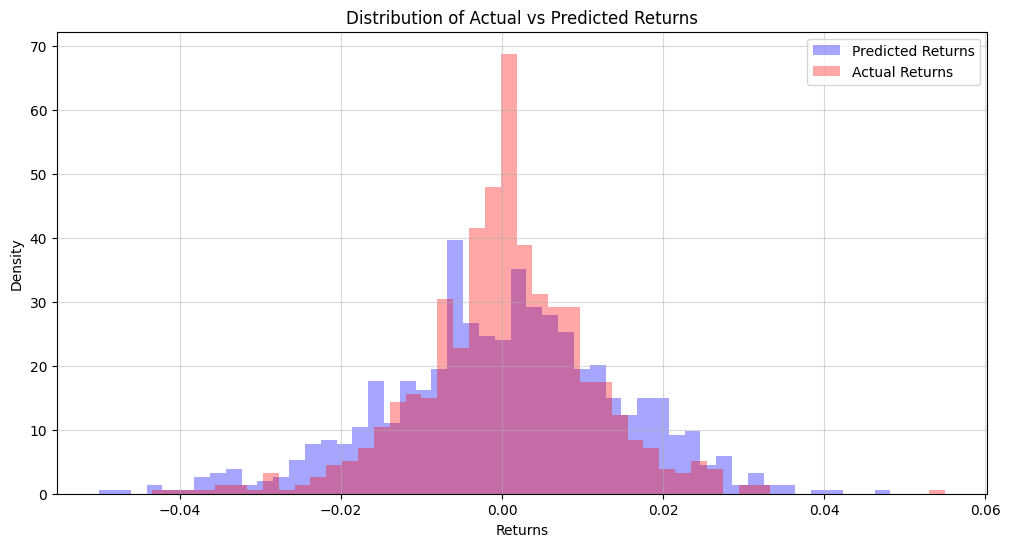

In [11]:
# Plot 4: Distribution of Actual vs Predicted Returns
plt.figure(figsize=(12, 6))
plt.hist(Y_pred, bins=50, alpha=0.35, label='Predicted Returns', color='blue', density=True)
plt.hist(Y_test, bins=50, alpha=0.35, label='Actual Returns', color='red', density=True)
plt.title("Distribution of Actual vs Predicted Returns")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* The two distributions overlap but not significantly, this means that the model captures market dynamics, but further tuning may be required.

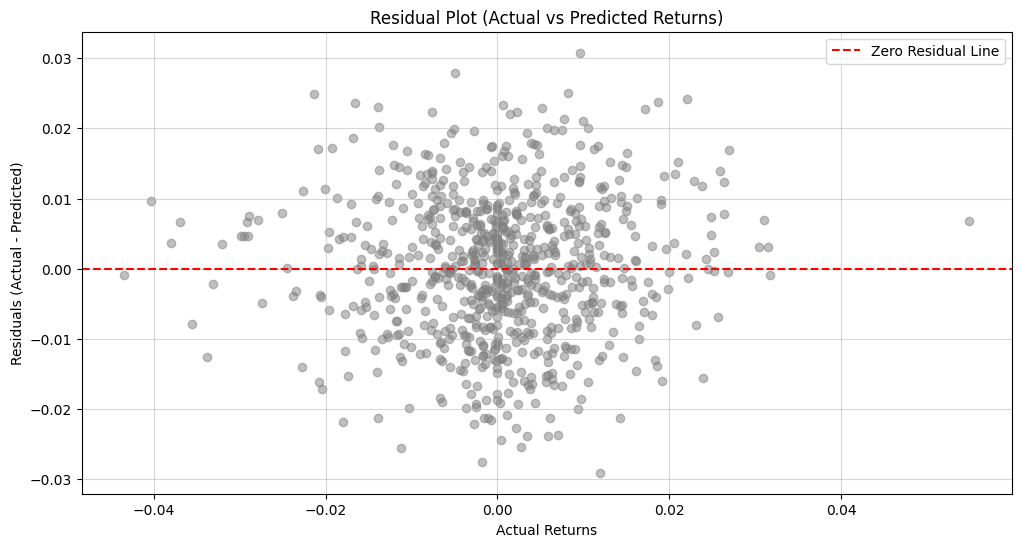

In [12]:
# Plot 5: Residual Plot (Actual - Predicted)
residuals = Y_test - Y_pred
plt.figure(figsize=(12, 6))
plt.scatter(Y_test, residuals, color='gray', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.title("Residual Plot (Actual vs Predicted Returns)")
plt.xlabel("Actual Returns")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* Ideally, residuals should be randomly scattered around zero, indicating no systematic bias. The emergence of patterns indcate the model may be missing nonlinearity or interactions.

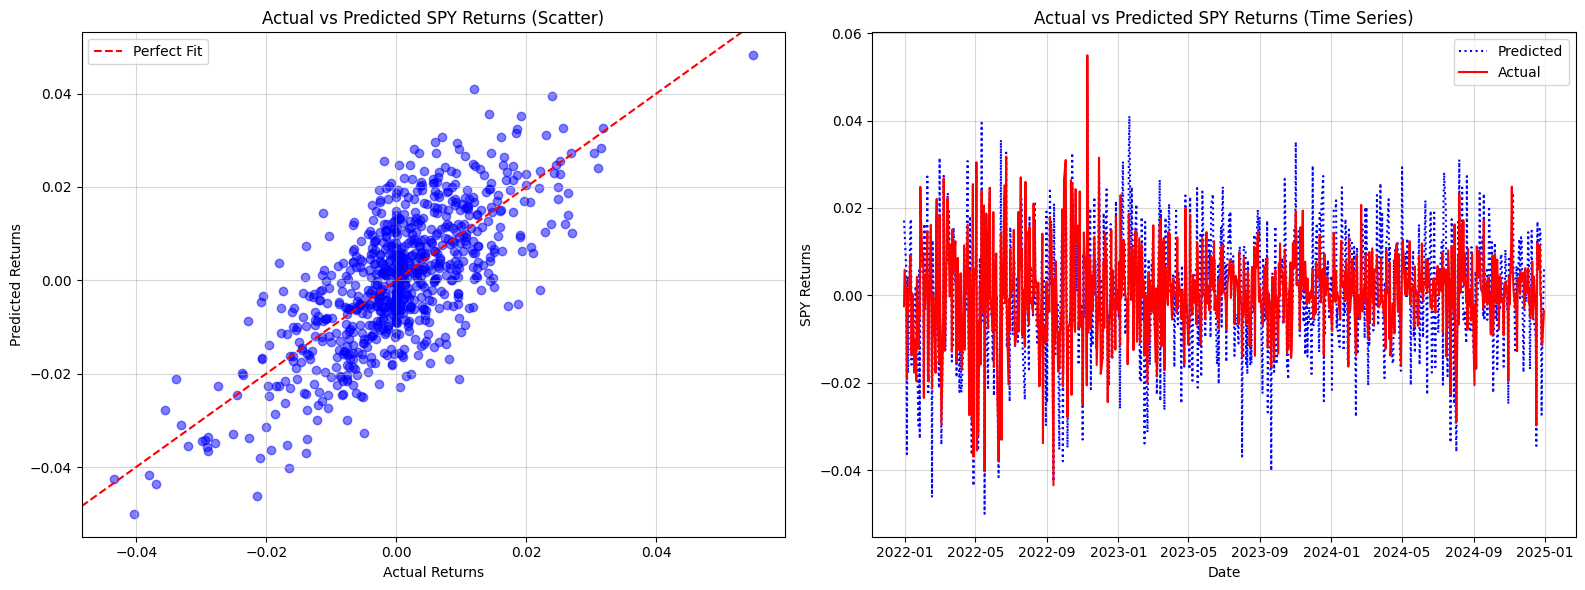

In [13]:
# Plot 7: Actual vs Predicted SPY Returns
plt.figure(figsize=(16, 6))  # Set the figure size for two subplots side by side

# Subplot 1: Scatter
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5)
plt.axline((0, 0), slope=1, color='red', linestyle="--", label="Perfect Fit")
plt.title("Actual vs Predicted SPY Returns (Scatter)")
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.legend()
plt.grid(alpha=0.5)

# Subplot 2: Time Series
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(Y_test.index, Y_pred, label='Predicted', color='blue', linestyle=':')
plt.plot(Y_test.index, Y_test.values, label='Actual', color='red', linestyle='-')
plt.title("Actual vs Predicted SPY Returns (Time Series)")
plt.xlabel("Date")
plt.ylabel("SPY Returns")
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

* In the scatter plot, the close alignment of predictions with the diagonal (perfect fit line), indicate that the model generalizes well. Clear deviations would indicate potential underfitting or overfitting.
* In the time series plot, large deviations suggest potential overfitting, underfitting, or missing predictive factors. A strong model will capture key directional movements, even if short-term fluctuations aren't perfectly predicted.

# 2) Hierarchical Clustering

Hierarchical Clustering Example on Financial Indices (SPY & QQQ)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


SPY Data Columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
QQQ Data Columns: MultiIndex([( 'Close', 'QQQ'),
            (  'High', 'QQQ'),
            (   'Low', 'QQQ'),
            (  'Open', 'QQQ'),
            ('Volume', 'QQQ')],
           names=['Price', 'Ticker'])


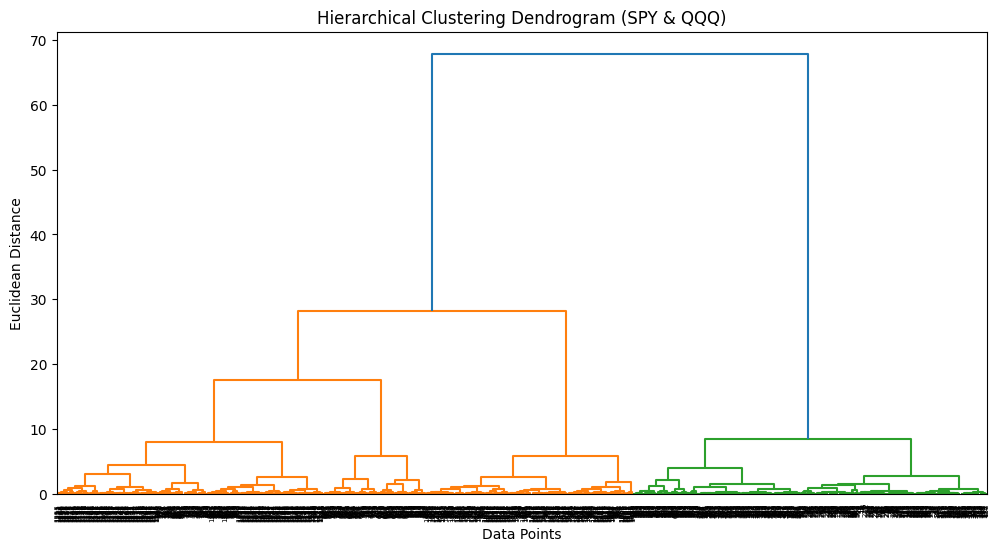

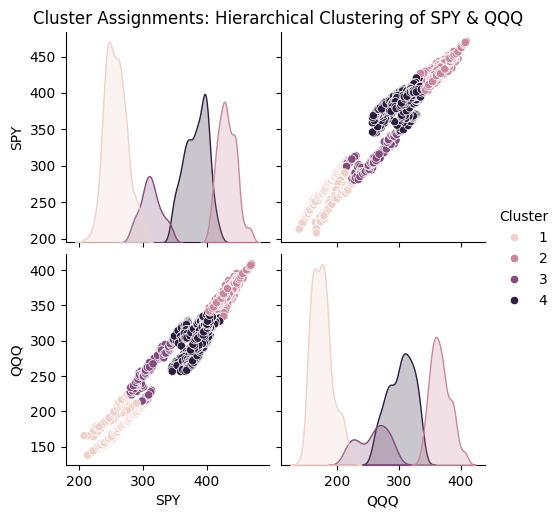

In [14]:
# Defining the date range for daily data from 2018 to 2023
start_date = "2018-01-01"
end_date   = "2023-12-31"

# Downloading historical data for SPY (S&P 500 ETF) and QQQ (Nasdaq-100 ETF)
spy_data  = yf.download("SPY", start=start_date, end=end_date)
qqq_data  = yf.download("QQQ", start=start_date, end=end_date)

# Debug: Print the column names to verify available columns
print("SPY Data Columns:", spy_data.columns)
print("QQQ Data Columns:", qqq_data.columns)

# Using the 'Adj Close' column if available; otherwise, fallback to 'Close'
spy_col = "Adj Close" if "Adj Close" in spy_data.columns else "Close"
qqq_col = "Adj Close" if "Adj Close" in qqq_data.columns else "Close"

# Creating DataFrames for the selected columns
spy_df = pd.DataFrame(spy_data[spy_col], columns=["SPY"])
qqq_df = pd.DataFrame(qqq_data[qqq_col], columns=["QQQ"])

# Merge the DataFrames on the date index and drop rows with missing values
indices_df = pd.merge(spy_df, qqq_df, left_index=True, right_index=True, how="inner").dropna()
if indices_df.empty:
    raise ValueError("Merged DataFrame is empty. Check the date range and ticker symbols.")

# -------------------------------
# Data Preprocessing
# -------------------------------
# Standardizing the data so both SPY and QQQ are on the same scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(indices_df)
subset_indices = pd.DataFrame(scaled_data, columns=indices_df.columns, index=indices_df.index)

# -------------------------------
# Hierarchical Clustering
# -------------------------------
# Defining the linkage method and distance metric
linkage_method = 'ward'
distance_metric = 'euclidean'

# Computing the linkage matrix using the scaled data
linked = linkage(subset_indices, method=linkage_method, metric=distance_metric)

# -------------------------------
# Dendrogram Visualization
# -------------------------------
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title("Hierarchical Clustering Dendrogram (SPY & QQQ)")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

# -------------------------------
# Cluster Assignment
# -------------------------------
# Defining a threshold distance for forming clusters (adjust as necessary)
threshold_distance = 10
clusters = fcluster(linked, threshold_distance, criterion='distance')

# Appending cluster labels to the original merged DataFrame
indices_df['Cluster'] = clusters

# -------------------------------
# Cluster Visualization
# -------------------------------
sns.pairplot(indices_df, hue="Cluster", diag_kind='kde')
plt.suptitle("Cluster Assignments: Hierarchical Clustering of SPY & QQQ", y=1.02)
plt.show()


Dendogram Illustration

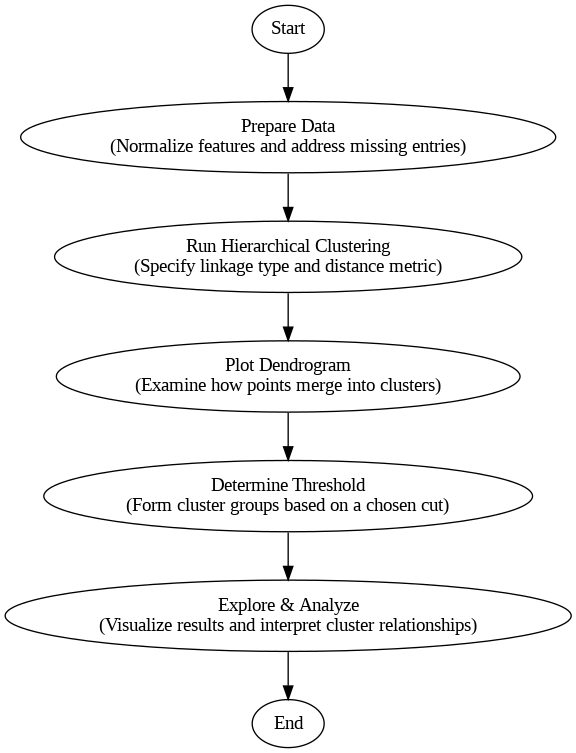

In [15]:
# !pip install graphviz

from graphviz import Digraph
from IPython.display import Image, display

# Creating a directed graph (no PDF output, just inline display)
dot = Digraph("Hierarchical_Clustering_Workflow", format="png")


dot.attr("node", shape="oval")

# Defining the nodes according to the exact wording in the diagram
dot.node("A", "Start")
dot.node("B", "Prepare Data\n(Normalize features and address missing entries)")
dot.node("C", "Run Hierarchical Clustering\n(Specify linkage type and distance metric)")
dot.node("D", "Plot Dendrogram\n(Examine how points merge into clusters)")
dot.node("E", "Determine Threshold\n(Form cluster groups based on a chosen cut)")
dot.node("F", "Explore & Analyze\n(Visualize results and interpret cluster relationships)")
dot.node("G", "End")

# Adding edges to reflect the workflow
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "E")
dot.edge("E", "F")
dot.edge("F", "G")


flowchart_png = dot.pipe(format='png')
display(Image(flowchart_png))

# 3) Principal Component Analysis

To illustrate the Principal Component Methodology, we will consider the high-quality market (HQM) corporate bond  **spot rate** data sourced from Fred Economics at different maturity dates (from 1year to 50years)
- According to Fred Economic Data, Spot rate for any maturity is defined as the yield maturity of a corporate bod that give a single payment at maturity. This implies that we'll be dealing with a zero-coupon bond for the model computation. The HQM (High Quality Markeet) methodology computes the spot rates of corporate bonds so as to ensure that rates remain consistent with other high-quality bonds. HQM helps identify  strong bonds in the market by using differebt metric suxh as bond per yield and spot rates. In this scenario spot rates will be used.

- We will consider spot rates with maturities of 1 year, 2 years, 3 years, 5 years, 7 years, 10 years, 15 years, 20 years, 25 years, 30 years s, 40 years, and lastly 50 years.

- For this scenario, we'll consider:

- 1 - 5years as Short-term spot rates

- 7- 15 years as Medium-term spot rates &

- 20 - 50 years as Long-term spot rates

### Load Packages

In [16]:
pip install fredapi

In [17]:
pip install pandas_datareader

In [18]:
pip install pca

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pca import pca

In [20]:
# Load in data from FRED Economics, drop null values
import pandas_datareader.data as web
import datetime
from datetime import datetime
import scipy as sp

# Plotting
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from fredapi import Fred

fred = Fred(api_key="4a686e78f0f4f1b2a194e90961e4c4f9")



**Load Dataset**

In [21]:
#Load 20-year spot rate data
start = datetime(1992, 12, 31)
end = datetime(2022, 12, 31)
data = [
    "HQMCB1YR",
    "HQMCB2YR",
    "HQMCB3YR",
    "HQMCB5YR",
    "HQMCB7YR",
    "HQMCB10YR",
    "HQMCB15YR",
    "HQMCB20YR",
    "HQMCB25YR",
    "HQMCB30YR",
    "HQMCB40YR",
    "HQMCB50YR",
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()

In [22]:
data.rename(
    columns={
        "HQMCB1YR": "1y",
        "HQMCB2YR": "2y",
        "HQMCB3YR": "3y",
        "HQMCB5YR": "5y",
        "HQMCB7YR": "7y",
        "HQMCB10YR": "10y",
        "HQMCB15YR": "15y",
        "HQMCB20YR": "20y",
        "HQMCB25YR": "25y",
        "HQMCB30YR": "30y",
        "HQMCB40YR": "40y",
        "HQMCB50YR": "50y",
    },
    inplace=True,
)
df = data.copy()
df.head(10)

,1y,2y,3y,5y,7y,10y,15y,20y,25y,30y,40y,50y
DATE,,,,,,,,,,,,
1993-01-01,4.71,5.23,5.87,6.91,7.40,7.68,8.10,8.56,8.89,9.10,9.35,9.50
1993-02-01,4.46,4.89,5.46,6.44,6.95,7.29,7.78,8.26,8.61,8.82,9.09,9.24
1993-03-01,4.26,4.65,5.19,6.16,6.67,7.03,7.53,8.00,8.33,8.55,8.80,8.96
1993-04-01,4.17,4.54,5.08,6.07,6.60,6.98,7.53,8.06,8.44,8.67,8.96,9.13
1993-05-01,4.22,4.64,5.17,6.10,6.60,6.98,7.57,8.14,8.54,8.80,9.10,9.29
1993-06-01,4.31,4.76,5.27,6.10,6.55,6.91,7.48,8.02,8.40,8.64,8.93,9.10
1993-07-01,4.25,4.68,5.15,5.92,6.36,6.72,7.27,7.77,8.13,8.35,8.62,8.78
1993-08-01,4.19,4.65,5.10,5.82,6.23,6.60,7.08,7.47,7.74,7.91,8.12,8.25
1993-09-01,4.08,4.51,4.91,5.52,5.89,6.25,6.78,7.24,7.56,7.76,8.01,8.16


## Approach 1: Performing PCA on Original Dataset

#### Exploratory Data Analysis

In [23]:
df.shape

(360, 12)

In [24]:
df2 = df.copy()

**Visualizing Spot rate Movement**

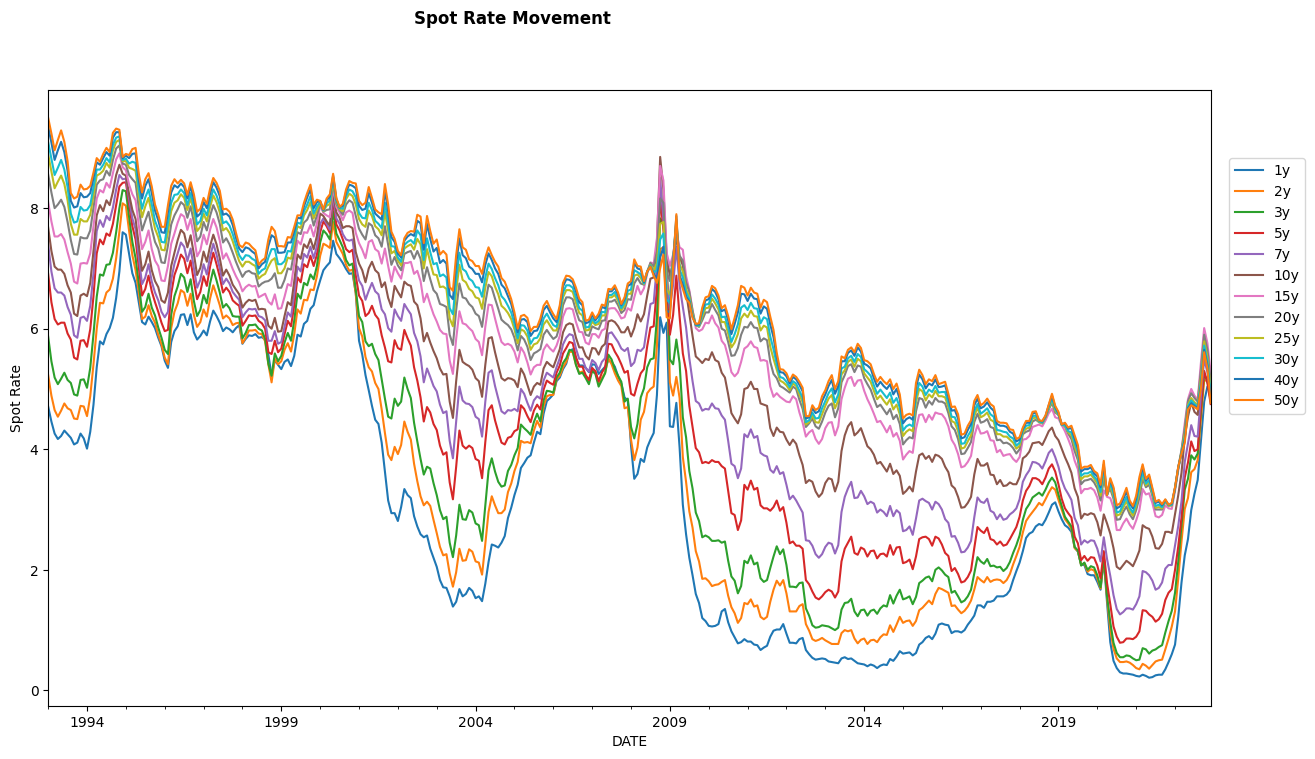

In [25]:
df.plot(figsize=(15, 8))
pyplot.ylabel("Spot Rate")
pyplot.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.suptitle(
    "Spot Rate Movement", fontweight="bold", horizontalalignment="right"
)
pyplot.show()

### Generating Principal Components

We will proceed to apply PCA to extract the signal inherent in the dataset and standardize the dataset into z-score to remove trend noise.

**Detrending Data**

In [26]:
df_std = (df - df.mean()) / df.std()
df_std.head()


,1y,2y,3y,5y,7y,10y,15y,20y,25y,30y,40y,50y
DATE,,,,,,,,,,,,
1993-01-01,0.680772,0.767557,0.942798,1.262268,1.394733,1.432798,1.525126,1.671681,1.768347,1.825112,1.885511,1.918655
1993-02-01,0.567530,0.609023,0.746758,1.024650,1.149777,1.196019,1.315502,1.477245,1.590864,1.650063,1.725639,1.760523
1993-03-01,0.476936,0.497116,0.617659,0.883091,0.997361,1.038167,1.151733,1.308734,1.413381,1.481265,1.547321,1.590227
1993-04-01,0.436169,0.445826,0.565063,0.837589,0.959257,1.007810,1.151733,1.347621,1.483107,1.556286,1.645703,1.693621
1993-05-01,0.458818,0.492454,0.608096,0.852756,0.959257,1.007810,1.177936,1.399471,1.546493,1.637559,1.731788,1.790933


#### Generate Covariance Matrix

The next step is to find the covariance of the standardized data.

In [27]:
cov_matrix_array = np.array(np.cov(df_std, rowvar=False))
cov_matrix_array

array([[1.        , 0.99289844, 0.97840973, 0.93891489, 0.90178999,
        0.85925474, 0.81517583, 0.79357111, 0.77847709, 0.76699159,
        0.75161636, 0.74186052],
       [0.99289844, 1.        , 0.99523628, 0.96707843, 0.93704486,
        0.90152855, 0.8611734 , 0.83798913, 0.8210795 , 0.80849052,
        0.79182705, 0.78130381],
       [0.97840973, 0.99523628, 1.        , 0.98664434, 0.96532132,
        0.9369717 , 0.90227271, 0.88104731, 0.86488606, 0.8527427 ,
        0.8365677 , 0.82629886],
       [0.93891489, 0.96707843, 0.98664434, 1.        , 0.99463699,
        0.97905004, 0.95593368, 0.94073258, 0.92777385, 0.91759638,
        0.90367565, 0.89466733],
       [0.90178999, 0.93704486, 0.96532132, 0.99463699, 1.        ,
        0.9944236 , 0.9797729 , 0.9674328 , 0.95564239, 0.94625801,
        0.93330319, 0.92483533],
       [0.85925474, 0.90152855, 0.9369717 , 0.97905004, 0.9944236 ,
        1.        , 0.99449842, 0.98386053, 0.97226232, 0.963139  ,
        0.95059255,

In [28]:
cov_df = pd.DataFrame(cov_matrix_array, columns=df.columns, index=df.columns)
cov_df

,1y,2y,3y,5y,7y,10y,15y,20y,25y,30y,40y,50y
1y,1.000000,0.992898,0.978410,0.938915,0.901790,0.859255,0.815176,0.793571,0.778477,0.766992,0.751616,0.741861
2y,0.992898,1.000000,0.995236,0.967078,0.937045,0.901529,0.861173,0.837989,0.821080,0.808491,0.791827,0.781304
3y,0.978410,0.995236,1.000000,0.986644,0.965321,0.936972,0.902273,0.881047,0.864886,0.852743,0.836568,0.826299
5y,0.938915,0.967078,0.986644,1.000000,0.994637,0.979050,0.955934,0.940733,0.927774,0.917596,0.903676,0.894667
7y,0.901790,0.937045,0.965321,0.994637,1.000000,0.994424,0.979773,0.967433,0.955642,0.946258,0.933303,0.924835
10y,0.859255,0.901529,0.936972,0.979050,0.994424,1.000000,0.994498,0.983861,0.972262,0.963139,0.950593,0.942355
15y,0.815176,0.861173,0.902273,0.955934,0.979773,0.994498,1.000000,0.995854,0.988029,0.981305,0.971626,0.965052
20y,0.793571,0.837989,0.881047,0.940733,0.967433,0.983861,0.995854,1.000000,0.997937,0.994699,0.989058,0.984828
25y,0.778477,0.821080,0.864886,0.927774,0.955642,0.972262,0.988029,0.997937,1.000000,0.999244,0.996478,0.993921
30y,0.766992,0.808491,0.852743,0.917596,0.946258,0.963139,0.981305,0.994699,0.999244,1.000000,0.998979,0.997442


#### Eigen-decomposition

Eigendecomposition of the covariance matrix forms the basis for principal component analysis (PCA). So we will proceed to find the eigenvalues and determine the **explained variance** - which simply represents eigenvectors as percentage of total variance

In [29]:
# Perform eigendecomposition

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)

# Put data into a DataFrame and save to excel
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})

eigenvalues

array([1.11689614e+01, 7.49364427e-01, 7.00720309e-02, 8.30036002e-03,
       3.28172610e-03, 1.72244489e-06, 2.13586597e-06, 3.67431243e-06,
       3.68780056e-06, 2.75081718e-06, 2.97475483e-06, 3.10992343e-06])

In [30]:
# We calculate explained variance

explained_variance = [round(variance / sum(eigenvalues), 3) for variance in eigenvalues]
explained_variance

[np.float64(0.931),
 np.float64(0.062),
 np.float64(0.006),
 np.float64(0.001),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [31]:
# Save output to Excel
columns = [
    "PC1",
    "PC2",
    "PC3",
    "PC4",
    "PC5",
    "PC6",
    "PC7",
    "PC8",
    "PC9",
    "PC10",
    "PC11",
    "PC12",
]
df_eigvec = pd.DataFrame(eigenvectors, columns=columns, index=df.columns)

df_eigvec.to_excel("df_eigvec.xlsx")
eigenvectors[0]

array([-0.26610576,  0.50934631, -0.41986093, -0.41587993,  0.52422094,
        0.1409032 ,  0.14578417, -0.051672  , -0.03434802, -0.00564706,
        0.02544312, -0.00844876])

In [32]:
df_eigvec

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
1y,-0.266106,0.509346,-0.419861,-0.415880,0.524221,0.140903,0.145784,-0.051672,-0.034348,-0.005647,0.025443,-0.008449
2y,-0.275975,0.443556,-0.132419,-0.068017,-0.443922,-0.540944,-0.433042,0.134434,0.083020,0.009939,-0.051527,0.001938
3y,-0.284671,0.353287,0.028108,0.233099,-0.511833,0.653422,0.211631,-0.006600,0.008953,0.022558,-0.039186,0.056002
5y,-0.294752,0.182858,0.185093,0.504951,0.156747,-0.444818,0.521558,-0.206155,-0.167473,-0.046581,0.126792,-0.084861
7y,-0.297338,0.073012,0.315938,0.350363,0.408248,0.240127,-0.645923,-0.078411,0.017601,-0.060657,0.145114,-0.104642
10y,-0.296904,-0.027703,0.456096,-0.141663,0.188220,-0.047471,0.162416,0.484176,0.239228,0.134013,-0.433991,0.347800
15y,-0.295296,-0.138553,0.373117,-0.472778,-0.146662,0.019446,0.070480,-0.080736,-0.186603,0.032290,-0.009456,-0.679368
20y,-0.294219,-0.205068,0.115221,-0.284192,-0.118291,-0.017885,-0.024115,-0.275732,-0.188796,-0.601685,0.178544,0.506826
25y,-0.292401,-0.243876,-0.078238,-0.088085,-0.055865,-0.013068,0.075527,0.145945,0.305863,0.417466,0.726551,0.123058
30y,-0.290637,-0.268281,-0.193259,0.018723,-0.023183,-0.019298,-0.123352,-0.471225,-0.258627,0.563736,-0.371244,0.212529


The columns are the factor loadings while the indices are the different maturities. Factor loadings represent the difference between the principal components (PC1, PC2, PC3,... PC12) and the original data features (i.e spot rates at different maturities). Fcctor loadings range between 1 (strong positive correlation), and -1 (strong neggative correlation). Factor loadings of 0 show weak correlation.

In [33]:
from itertools import accumulate

df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(
    df_eigval["Eigenvalues"]
)
df_eigval["Cumulative Explained Variance"] = list(
    accumulate(df_eigval["Explained proportion"])
)

# Format as percentage
df_eigval.style.format({"Explained proportion": "{:.2%}"})
df_eigval.style.format({"Cumulative Explained Variance": "{:.2%}"})

,Eigenvalues,Explained proportion,Cumulative Explained Variance
0,11.168961,0.930747,93.07%
1,0.749364,0.062447,99.32%
2,0.070072,0.005839,99.90%
3,0.008300,0.000692,99.97%
4,0.003282,0.000273,100.00%
5,0.000002,0.000000,100.00%
6,0.000002,0.000000,100.00%
7,0.000004,0.000000,100.00%
8,0.000004,0.000000,100.00%
9,0.000003,0.000000,100.00%


Upon combining the eigenvalues, explained variance and cummulative variance, we are able to determine the combined variation of the components.

#### Factor Loadings - Visualization

**First Factor Loading - PC1**

The first factor loading (PC1) is a representation of the parallel shift in the yield curve.

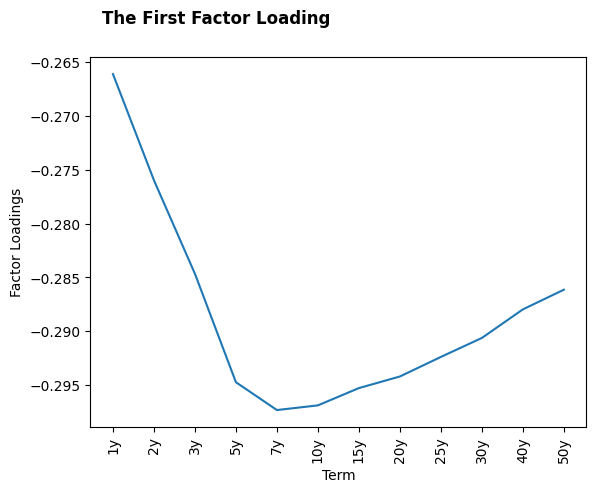

In [34]:
fig, ax = pyplot.subplots()

pyplot.plot(df_eigvec["PC1"])
pyplot.suptitle(
    "The First Factor Loading", fontweight="bold", horizontalalignment="right"
)
pyplot.ylabel("Factor Loadings")
ax.set_xticks(np.arange(12))
ax.set_xticklabels(df.columns, rotation="vertical")
pyplot.xlabel("Term")
pyplot.show()

The first factor loading (PC1) shows a steady decline in the rate by 0.031 base points from year 1 to year 7, but gaining momentum in the positive direction.

**Second Factor Loading - PC2**

The second factor loading (PC2) depicts slope change in the yield curve as we transit from short term rates to long-term rates. Additionally, it considers sector-specific variations in data.

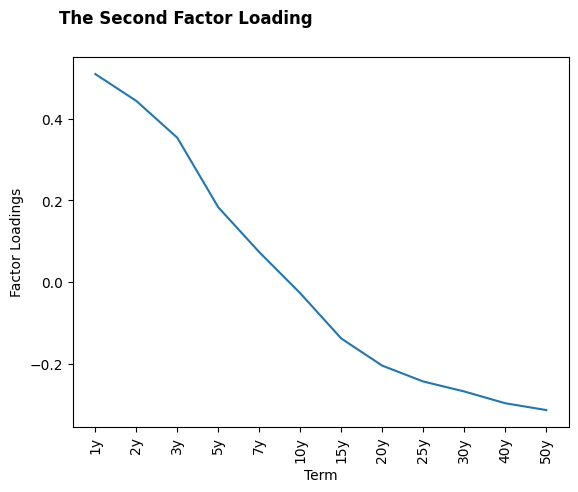

In [35]:
fig, ax = pyplot.subplots()

pyplot.plot(df_eigvec["PC2"])
pyplot.suptitle(
    "The Second Factor Loading", fontweight="bold", horizontalalignment="right"
)
pyplot.ylabel("Factor Loadings")
ax.set_xticks(np.arange(12))
ax.set_xticklabels(df.columns, rotation="vertical")
pyplot.xlabel("Term")
pyplot.show()

The figure above shows that slope moves in a particular direction from year 1 to year 50.

**Third Factor Loading - PC3**

The third factor loading (PC3) is a representation of the curvature shift or twist in the curve. It practically explains the niche minor sector-specific variance in the data.

<ipython-input-36-2fbfe533aaa4>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.columns, rotation="vertical")


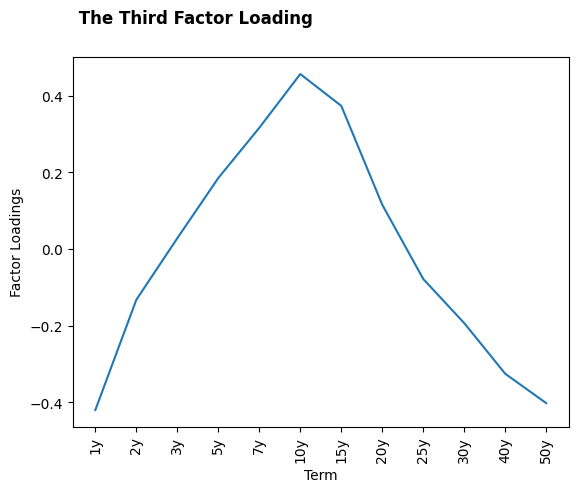

In [36]:
fig, ax = pyplot.subplots()

pyplot.plot(df_eigvec["PC3"])
pyplot.suptitle(
    " The Third Factor Loading", fontweight="bold", horizontalalignment="right"
)
pyplot.ylabel("Factor Loadings")


ax.set_xticklabels(df.columns, rotation="vertical")
pyplot.xlabel("Term")
pyplot.show()

The third factor loading (PC3) (as shown in the figure above) shows that there a curvature shift in the 10th year. This reflects the effect of short term shocks and minor changes in the 10th year.

#### Scree Plot

Scree plot visualizes the rate at which the explained variance is declining as the principal components progress. This plot halp us visualize the most significant PCs on the curve. The insignificant PCs flattens while the significant PCs are steep and give the representative measure of the cummulative explained variance.

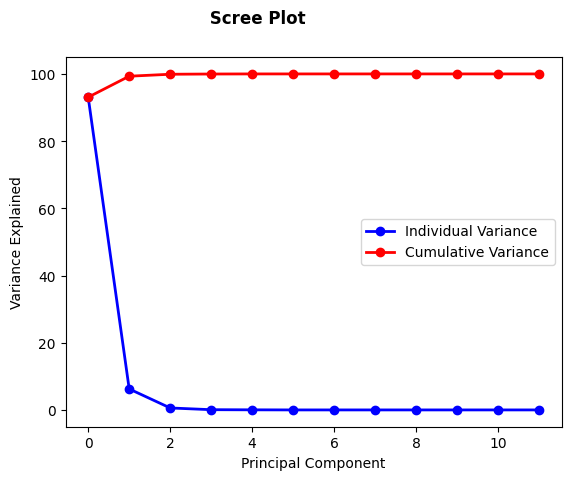

In [37]:
PC_values = np.arange(12)
pyplot.plot(
    PC_values, df_eigval["Explained proportion"] * 100, "o-", linewidth=2, color="blue"
)
pyplot.plot(
    PC_values,
    df_eigval["Cumulative Explained Variance"] * 100,
    "o-",
    linewidth=2,
    color="red",
)
pyplot.suptitle(" Scree Plot", fontweight="bold", horizontalalignment="right")
pyplot.xlabel("Principal Component")
pyplot.ylabel("Variance Explained")
pyplot.legend(["Individual Variance", "Cumulative Variance"])
pyplot.show()

The figure above shows that only PC1 and PC2 explains more than 99% of the variance in the dataset

#### Determine the Principal Components

In [38]:
principal_components = df_std.dot(eigenvectors)
principal_components.columns = df_eigvec.columns
principal_components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
DATE,,,,,,,,,,,,
1993-01-01,-4.955267,-1.324163,-0.147021,0.125228,0.050883,0.001242,0.000612,-0.000489,-0.000366,-0.000933,-0.000879,0.000357
1993-02-01,-4.299232,-1.319903,-0.250704,0.078897,0.044581,0.001451,-0.000712,0.000875,0.004395,-0.000317,0.000942,-0.002047
1993-03-01,-3.774602,-1.241688,-0.255398,0.071503,0.052641,-0.000889,-0.000610,0.000291,-0.004183,-0.000340,-0.003096,-0.001723
1993-04-01,-3.812423,-1.420832,-0.356302,0.065685,0.044618,-0.000646,-0.000957,0.001261,0.002197,-0.000142,0.002143,-0.000345
1993-05-01,-3.965824,-1.478281,-0.439995,0.070559,0.002869,-0.001116,-0.002583,-0.000330,-0.002972,0.000444,-0.001112,0.000635


From the table, only the first three principal components account for the overall cumulative variance.

**PCA plots**

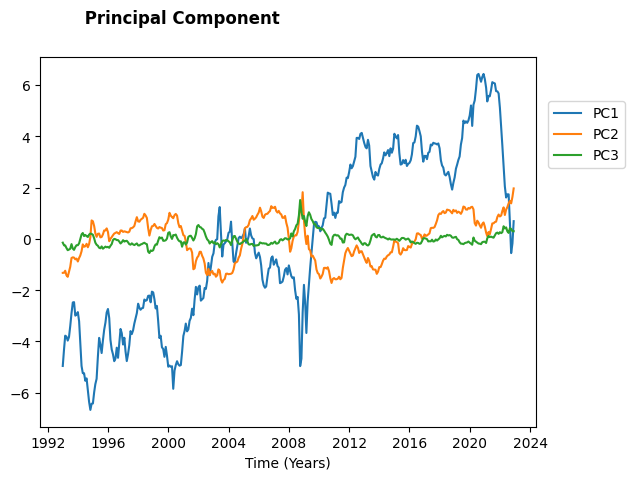

In [39]:
pyplot.plot(principal_components[["PC1", "PC2", "PC3"]])
pyplot.xlabel("Time (Years)")
pyplot.suptitle(
    " Principal Component", fontweight="bold", horizontalalignment="right"
)
pyplot.legend(["PC1", "PC2", "PC3"], bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.show()

The figure above shows that PC1 possesses the highest volatility.

Define PCA function that combines eigendecomposition and factor loading plots

In [40]:
def PCA_CALC(df, num_reconstruct):
    df -= df.mean(axis=0) / df.std()
    R = np.cov(df, rowvar=False)
    eigen_values, eigen_vectors = sp.linalg.eigh(R)
    eigen_vectors = eigen_vectors[:, np.argsort(eigen_values)[::-1]]
    eigen_values = eigen_values[np.argsort(eigen_values)[::-1]]
    eigen_vectors = eigen_vectors[:, :num_reconstruct]

    return np.dot(eigen_vectors.T, df.T).T, eigen_values, eigen_vectors

In [41]:
scores, evals, evecs = PCA_CALC(df, 12)

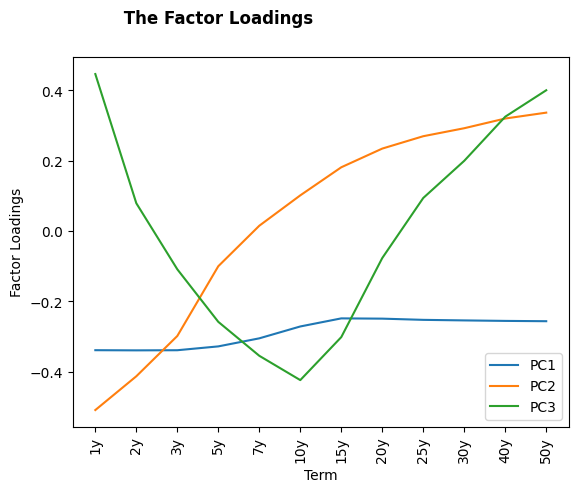

In [42]:
fig, ax = pyplot.subplots()

evecs = pd.DataFrame(evecs)
pyplot.plot(evecs.loc[:, 0:2])
pyplot.suptitle(
    " The Factor Loadings", fontweight="bold", horizontalalignment="right"
)
pyplot.legend(["PC1", "PC2", "PC3"], loc="lower right")
pyplot.ylabel("Factor Loadings")
ax.set_xticks(np.arange(12))
ax.set_xticklabels(df.columns, rotation="vertical")
pyplot.xlabel("Term")
pyplot.show()

The figure shows the economic implication of all 3 PCs. PCI depicts parallel shift, PCS shows slope moving in same direction, and PC3 shows curvuture shift

**Reconstructed Data from Factor Loadings**

The reconstruction of the dataset entails generating the original dataset from the factor loadings.

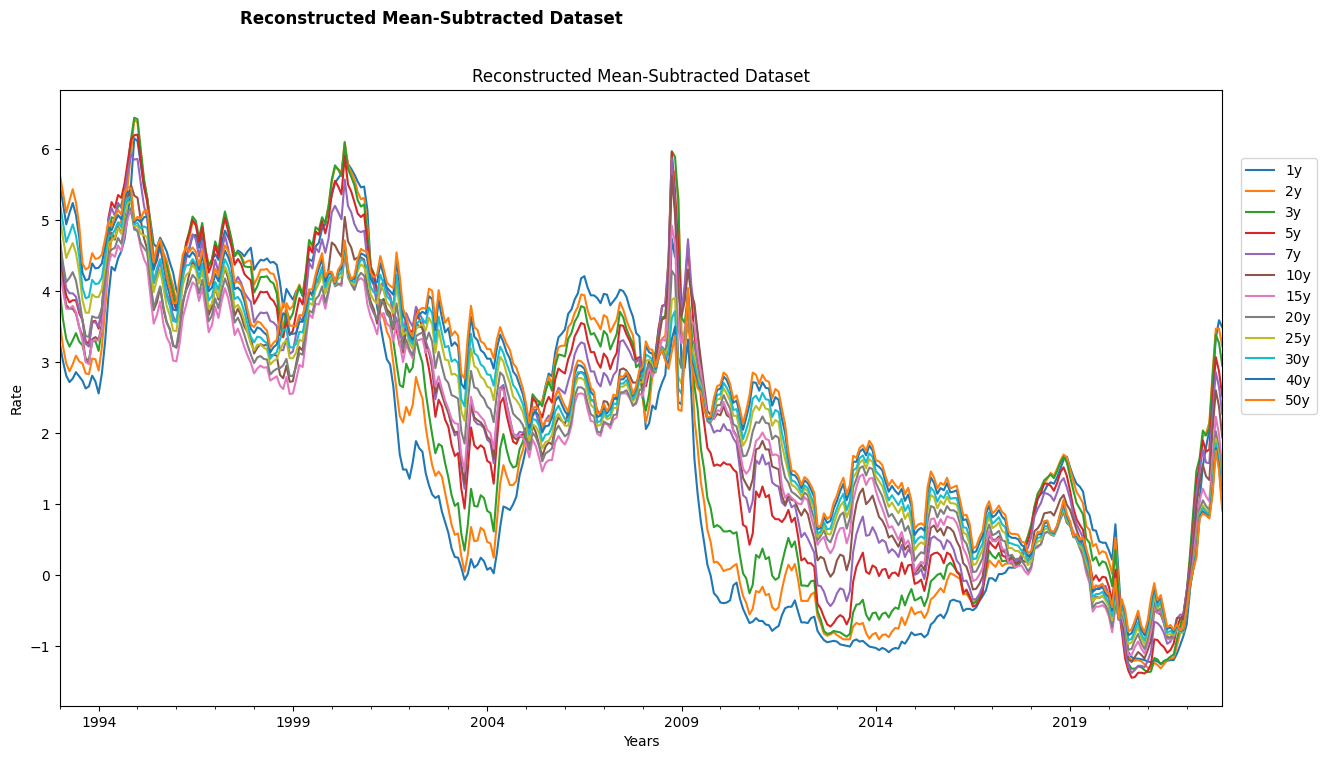

In [43]:
reconst = pd.DataFrame(np.dot(scores, evecs.T), index=df.index, columns=df.columns)

reconst.plot(figsize=(15, 8))
pyplot.ylabel("Rate")
pyplot.xlabel("Years")
pyplot.title("Reconstructed Mean-Subtracted Dataset")
pyplot.suptitle(
    "Reconstructed Mean-Subtracted Dataset",
    fontweight="bold",
    horizontalalignment="right",
)
pyplot.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.show()

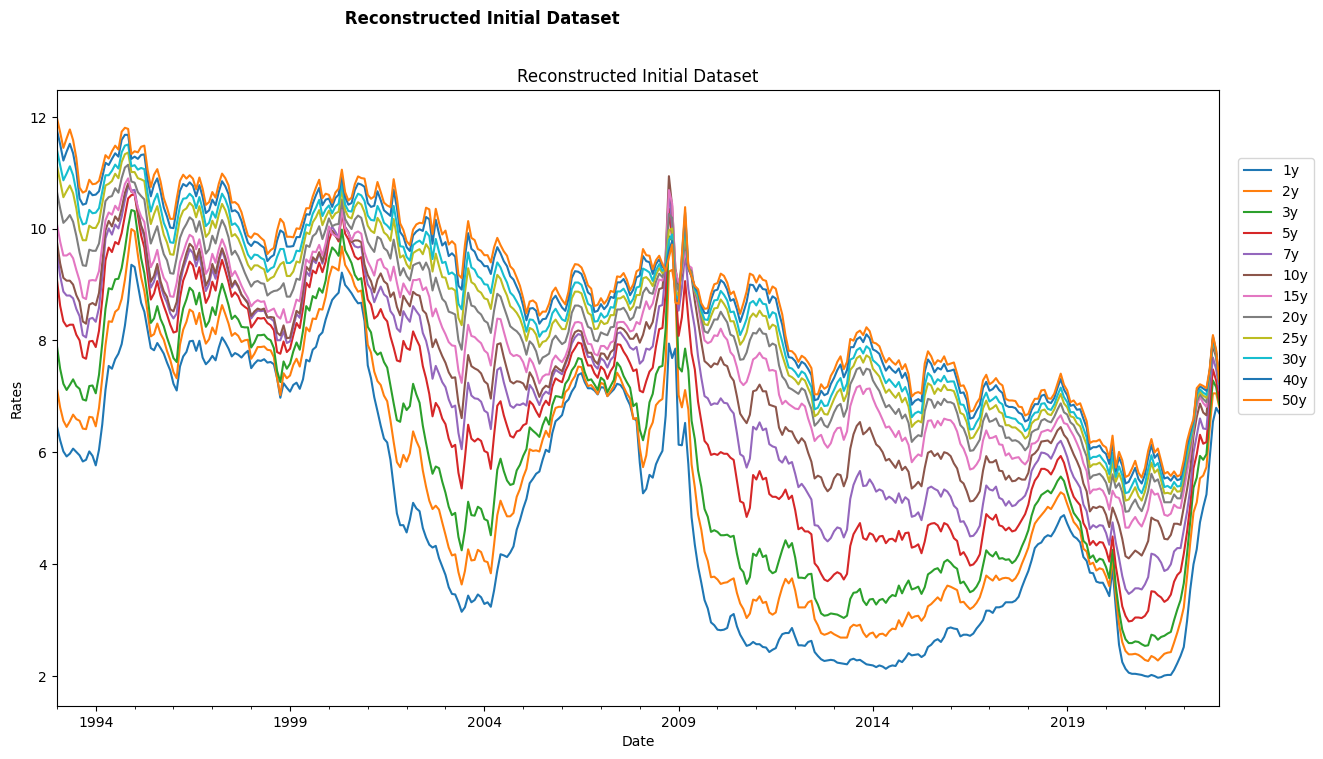

In [44]:
for cols in reconst.columns:
    reconst[cols] = reconst[cols] + df2.mean(axis=0)[cols]

reconst.plot(figsize=(15, 8))
pyplot.xlabel("Date")
pyplot.ylabel("Rates")
pyplot.title("Reconstructed Initial Dataset")
pyplot.suptitle(
    " Reconstructed Initial Dataset",
    fontweight="bold",
    horizontalalignment="right",
)
pyplot.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.show()

On comparing the Fig. 8 (mean-normalised dataset) and Fig 9 (the reconstructed initial dataset), it is observed that the reconstructed dataset is more volatile than the mean-normalised one.

**Correlation of Reconstructed Dataset**

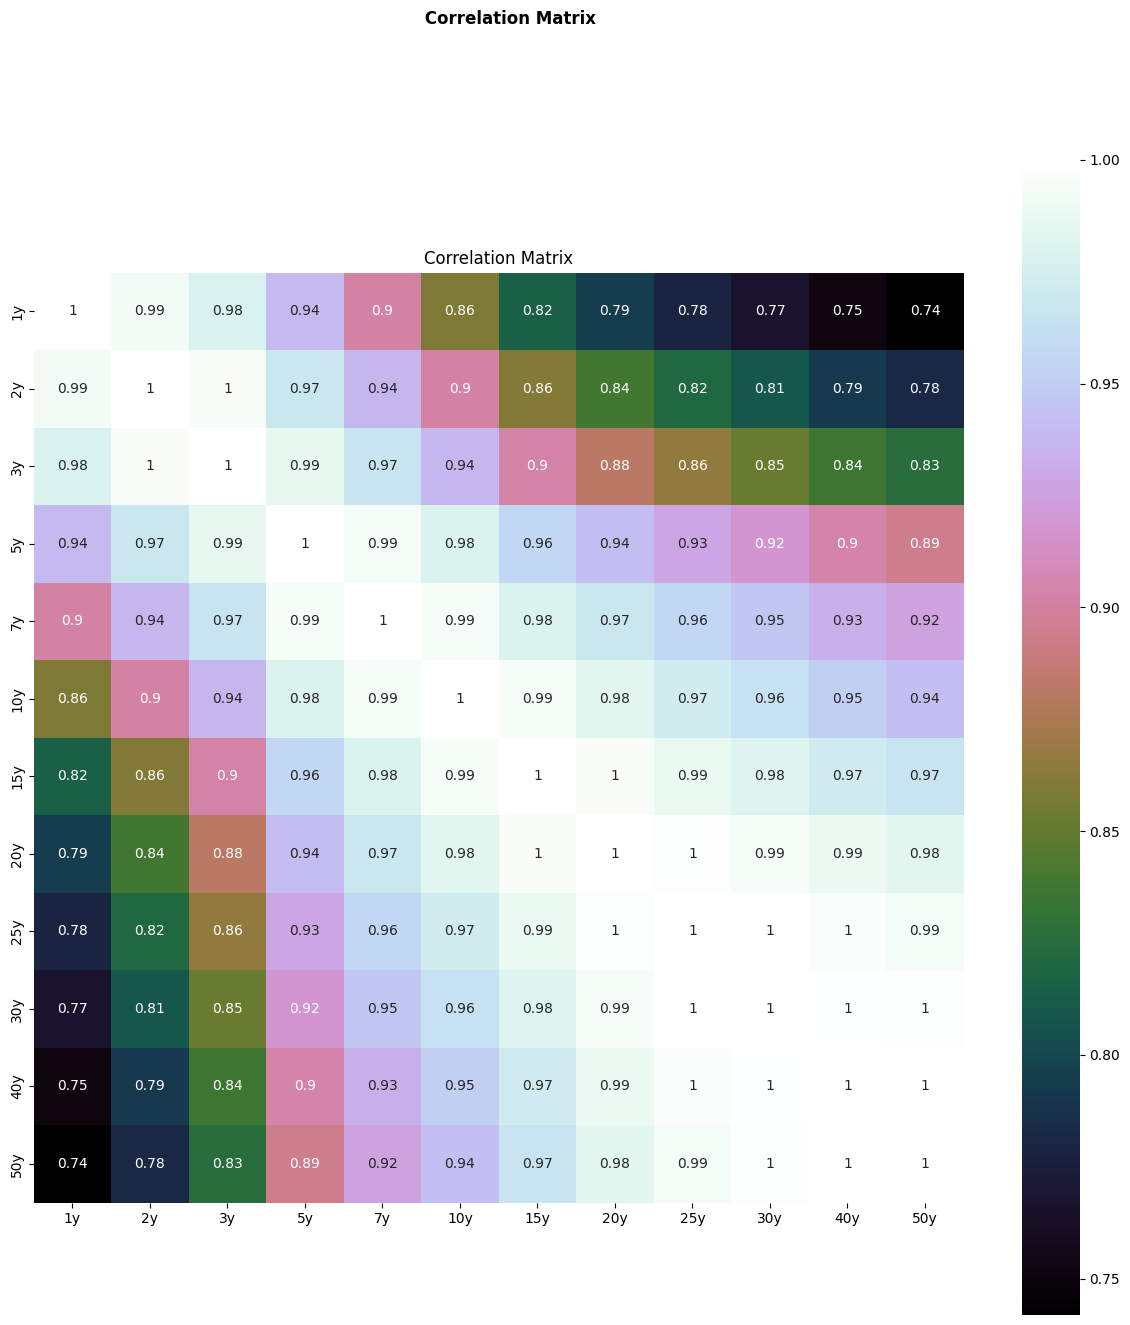

In [45]:
# correlation
correlation = df.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title("Correlation Matrix")
pyplot.suptitle(
    " Correlation Matrix", fontweight="bold", horizontalalignment="right"
)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="cubehelix");

## Approach 2: Performing PCA on  Rescaled Dataset

Our analyses thus far have proved that the PCA algorithm is susceptible to variation, whereas the mean-normalised (standardised) dataset have lower variance. Hence, we will the applying standardised model fit on the data set before running the PCA algoirthm. In this approach, we will consider applying the StandardScaler model fit on the original dataset before implementing the principal component analysis (PCA) algorithm.

In [46]:
scaler = StandardScaler().fit(df)
rescaleddf = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
# summarize transformed data
df.dropna(how="any", inplace=True)
rescaleddf.dropna(how="any", inplace=True)
rescaleddf.head(2)

,1y,2y,3y,5y,7y,10y,15y,20y,25y,30y,40y,50y
DATE,,,,,,,,,,,,
1993-01-01,0.681719,0.768625,0.944110,1.264025,1.396674,1.434792,1.527249,1.674008,1.770808,1.827652,1.888135,1.921326
1993-02-01,0.568320,0.609870,0.747797,1.026076,1.151378,1.197684,1.317333,1.479301,1.593078,1.652359,1.728041,1.762973


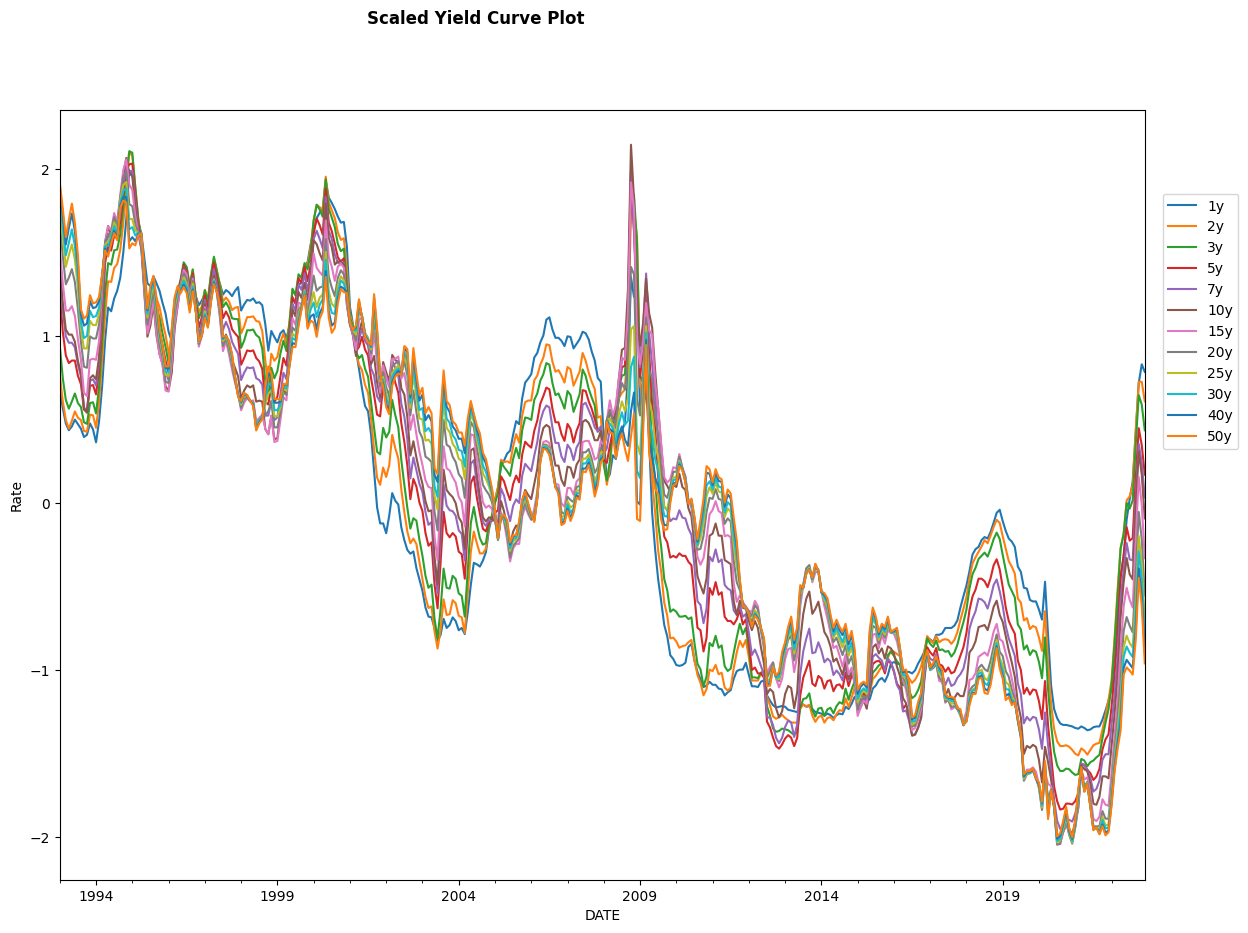

In [47]:
rescaleddf.plot(figsize=(14, 10))
pyplot.ylabel("Rate")
pyplot.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.suptitle(
    "Scaled Yield Curve Plot", fontweight="bold", horizontalalignment="right"
)
pyplot.show()

#### Applying PCA Model Fit to Rescaled Data

In [48]:
model = PCA()
PrincipalComponent = model.fit(rescaleddf)

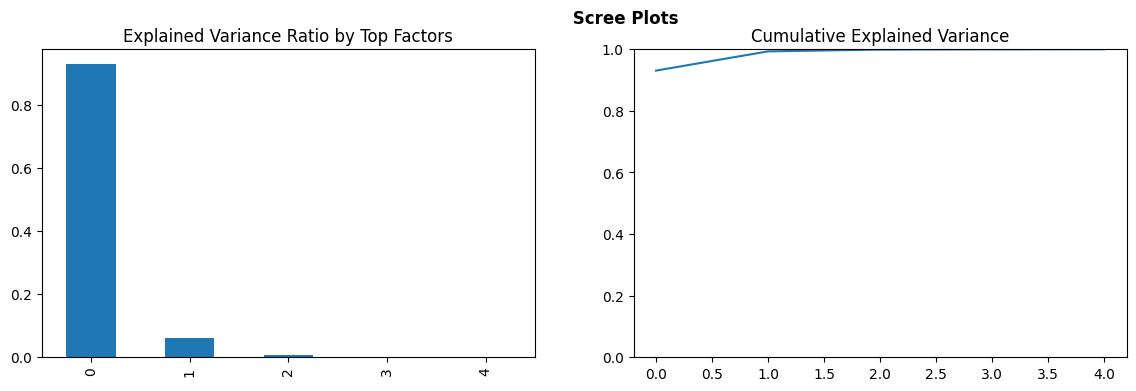

In [49]:
NumEigenvalues = 5
fig, axes = pyplot.subplots(ncols=2, figsize=(14, 4))
pd.Series(model.explained_variance_ratio_[:NumEigenvalues]).sort_values(
    ascending=False
).plot.bar(title="Explained Variance Ratio by Top Factors", ax=axes[0])
pd.Series(model.explained_variance_ratio_[:NumEigenvalues]).cumsum().plot(
    ylim=(0, 1), ax=axes[1], title="Cumulative Explained Variance"
)

# explained_variance
pd.Series(np.cumsum(model.explained_variance_ratio_)).to_frame(
    "Explained Variance_Top 5"
).head(NumEigenvalues).style.format("{:,.2%}".format)
pyplot.suptitle(" Scree Plots", fontweight="bold", horizontalalignment="left")
pyplot.show()

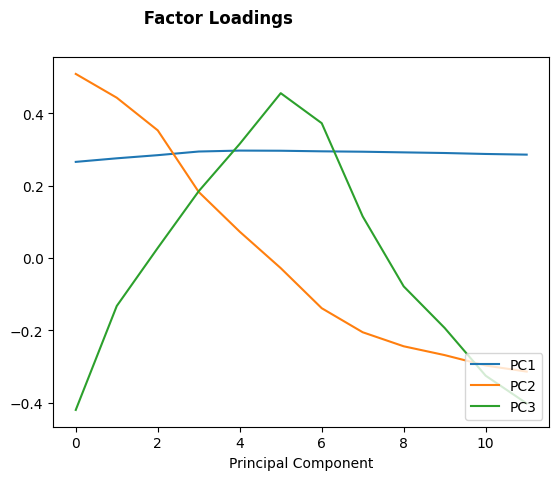

In [50]:
pyplot.plot(model.components_[0:3].T)
pyplot.xlabel("Principal Component")
pyplot.suptitle(
    " Factor Loadings", fontweight="bold", horizontalalignment="right"
)
pyplot.legend(["PC1", "PC2", "PC3"], loc="lower right")
pyplot.show()

In [51]:
#fit PCA model on rescaled data
model = PCA().fit(rescaleddf)
columns = ["pca_comp_%i" % i for i in range(12)]
model.explained_variance_ratio_
df_pca = pd.DataFrame(
    model.transform(rescaleddf), columns=columns, index=rescaleddf.index
)
df_pca.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,pca_comp_11
DATE,,,,,,,,,,,,
1993-01-01,4.962164,-1.326006,-0.147226,0.125402,0.050954,-0.000366,-0.000490,-0.000357,-0.000880,0.000934,-0.000612,0.001244
1993-02-01,4.305215,-1.321740,-0.251053,0.079007,0.044643,0.004401,0.000876,0.002050,0.000943,0.000317,0.000713,0.001453
1993-03-01,3.779855,-1.243416,-0.255753,0.071602,0.052714,-0.004188,0.000291,0.001725,-0.003101,0.000340,0.000611,-0.000891
1993-04-01,3.817730,-1.422810,-0.356798,0.065777,0.044680,0.002200,0.001262,0.000346,0.002146,0.000142,0.000958,-0.000647
1993-05-01,3.971344,-1.480339,-0.440608,0.070657,0.002873,-0.002976,-0.000330,-0.000636,-0.001113,-0.000445,0.002586,-0.001117


PCA dataset in this approach in similar to that in approach 1. The factoring loading plots and the cumulative explained variance are same as one in the previous approach.

In [52]:
# get the component variance
# Proportion of Variance (from PC1 to PC12)
model.explained_variance_ratio_

array([9.30746783e-01, 6.24470356e-02, 5.83933591e-03, 6.91696669e-04,
       2.73477175e-04, 3.07316713e-07, 3.06192702e-07, 2.59160286e-07,
       2.47896236e-07, 2.29234765e-07, 1.77988831e-07, 1.43537075e-07])

In [53]:
# Cumulative proportion of variance (from PC1 to PC6)
np.cumsum(model.explained_variance_ratio_)

array([0.93074678, 0.99319382, 0.99903315, 0.99972485, 0.99999833,
       0.99999864, 0.99999894, 0.9999992 , 0.99999945, 0.99999968,
       0.99999986, 1.        ])

In [54]:
# component loadings or weights (correlation coefficient between original variables and the component)
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = model.components_
num_pc = model.n_features_in_
pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df["variable"] = df.columns.values
loadings_df = loadings_df.set_index("variable")
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
variable,,,,,,,,,,,,
1y,0.266106,0.509346,-0.419861,-0.415880,0.524221,-0.034348,-0.051672,0.008449,0.025443,0.005647,-0.145784,0.140903
2y,0.275975,0.443556,-0.132419,-0.068017,-0.443922,0.083020,0.134434,-0.001938,-0.051527,-0.009939,0.433042,-0.540944
3y,0.284671,0.353287,0.028108,0.233099,-0.511833,0.008953,-0.006600,-0.056002,-0.039186,-0.022558,-0.211631,0.653422
5y,0.294752,0.182858,0.185093,0.504951,0.156747,-0.167473,-0.206155,0.084861,0.126792,0.046581,-0.521558,-0.444818
7y,0.297338,0.073012,0.315938,0.350363,0.408248,0.017601,-0.078411,0.104642,0.145114,0.060657,0.645923,0.240127
10y,0.296904,-0.027703,0.456096,-0.141663,0.188220,0.239228,0.484176,-0.347800,-0.433991,-0.134013,-0.162416,-0.047471
15y,0.295296,-0.138553,0.373117,-0.472778,-0.146662,-0.186603,-0.080736,0.679368,-0.009456,-0.032290,-0.070480,0.019446
20y,0.294219,-0.205068,0.115221,-0.284192,-0.118291,-0.188796,-0.275732,-0.506826,0.178544,0.601685,0.024115,-0.017885
25y,0.292401,-0.243876,-0.078238,-0.088085,-0.055865,0.305863,0.145945,-0.123058,0.726551,-0.417466,-0.075527,-0.013068


**Correlation Matrix for Factor Loadings**

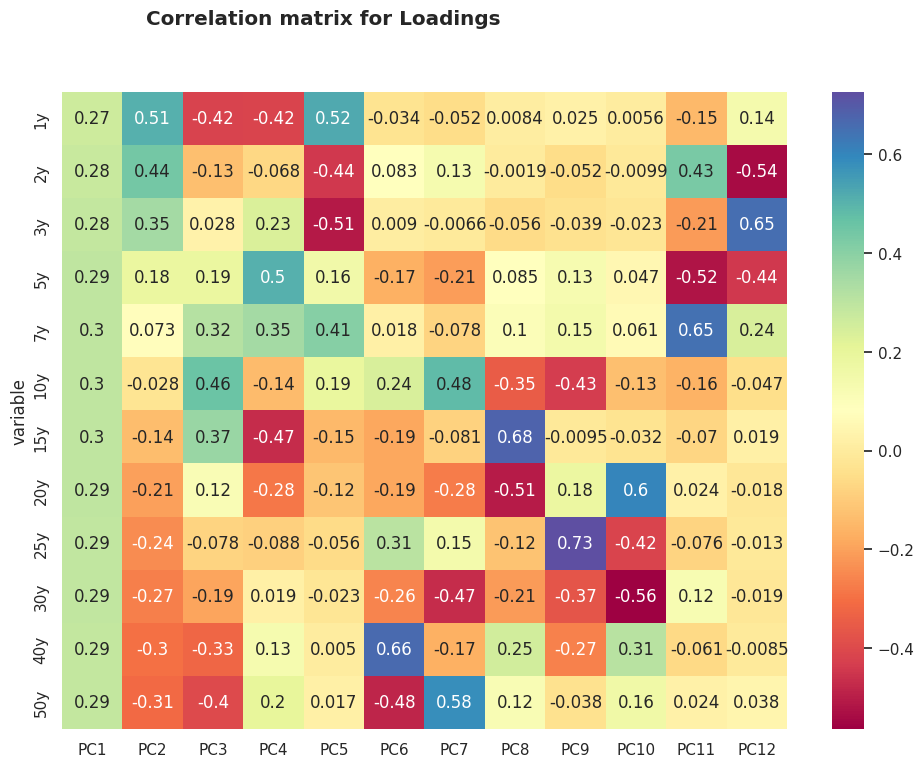

In [55]:
# positive and negative values in component loadings reflects the positive and negative
# correlation of the variables with the PCs. Except A and B, all other variables have
# positive projection on first PC.

# get correlation matrix plot for loadings

import seaborn as sns

sns.set(rc={"figure.figsize": (11.7, 8.27)})
import matplotlib.pyplot as plt

ax = sns.heatmap(loadings_df, annot=True, cmap="Spectral")
pyplot.suptitle(
    "Correlation matrix for Loadings",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()


In [56]:
# get eigenvalues (variance explained by each PC)
model.explained_variance_

array([1.12000727e+01, 7.51451793e-01, 7.02672176e-02, 8.32348080e-03,
       3.29086740e-03, 3.69807298e-06, 3.68454728e-06, 3.11858617e-06,
       2.98304105e-06, 2.75847963e-06, 2.14181546e-06, 1.72724279e-06])

#### Applying the PCA model fit to Rescaled Data - with 2 PCs

As in the previous approach, we will apply PCA algorithm with 2PCs only since they account for 99% of the cumulated explained variance

In [57]:
# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(rescaleddf)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


#### Biplot  Visualization

 Biplot without the scores
[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


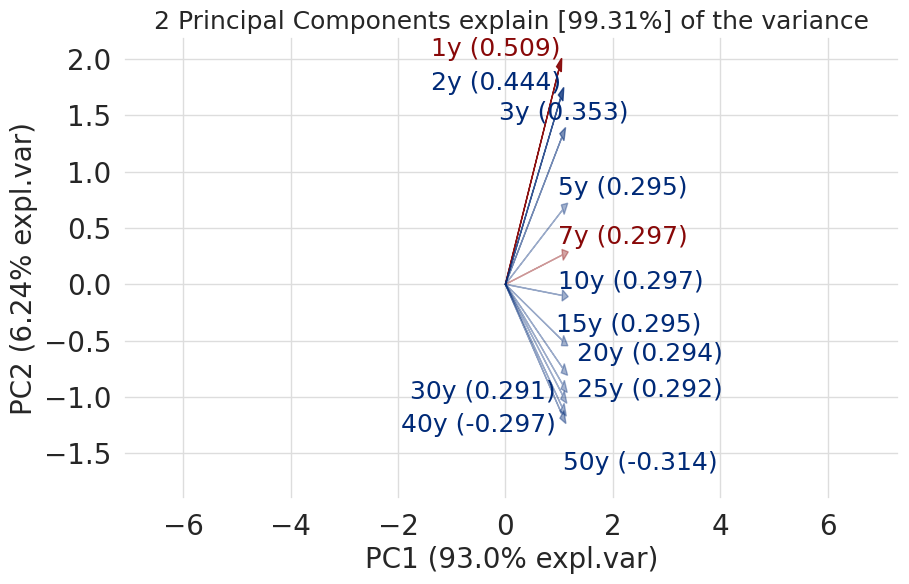

In [58]:
# Make biplot with the number of features
print("\033[1m" + " Biplot without the scores" + "\033[0m")
fig, ax = model.biplot(cmap=None, label=False, legend=False, figsize=(10, 6))

From the biplot, we can see long-term interest rates are highly correlated, even more than short-term rates. This is because the angle between them is smaller. Comparing short-term and long-term interest rates, we can conclude that they are positively correlated as the angle between them is wider. The mid-term interest rates seem not to be correlated with both the short- and long-term interest rates.

# Save to PDF

In [ ]:
from google.colab import files
import subprocess

# Upload the notebook file
uploaded = files.upload()

# Specify the notebook name (from the uploaded file)
notebook_name = list(uploaded.keys())[0]
html_name = notebook_name.replace('.ipynb', '.html')

# Convert the notebook to HTML
subprocess.run(["jupyter", "nbconvert", "--to", "html", notebook_name])

# Verify the HTML file is created
!ls /content

# Download the HTML file
files.download(html_name)

Saving MLiF_GWP1_g8507.ipynb to MLiF_GWP1_g8507 (1).ipynb
'MLiF_GWP1_g8507 (1).html'    MLiF_GWP1_g8507.html    sample_data
'MLiF_GWP1_g8507 (1).ipynb'   MLiF_GWP1_g8507.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>